In [1]:
from transformers import BertConfig
from gnn import GNNTrainer
from movie_lens_loader import MovieLensLoader
from llm import PromptBertClassifier, VanillaBertClassifier, AddingEmbeddingsBertClassifierBase

import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import DataLoader
import networkx as nx
import os
import pandas as pd
import ast

In [2]:
config = BertConfig.from_pretrained("google/bert_uncased_L-2_H-128_A-2")
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
KGE_DIMENSIONS = [KGE_DIMENSION_PROMPT, KGE_DIMENSION_ADDING] # Output Dimension of the GNN Encoder.
model_max_length_vanilla_and_embedding = 256
model_max_length_prompt = 512
movie_lens_loader = MovieLensLoader(kge_dimensions = KGE_DIMENSIONS)
gnn_trainer_prompt =    GNNTrainer(movie_lens_loader.data, kge_dimension = KGE_DIMENSION_PROMPT)
gnn_trainer_prompt.get_embeddings(movie_lens_loader)
gnn_trainer_adding =    GNNTrainer(movie_lens_loader.data, hidden_channels=KGE_DIMENSION_ADDING, kge_dimension = KGE_DIMENSION_ADDING)
gnn_trainer_adding.get_embeddings(movie_lens_loader)
vanilla_bert_only_classifier = VanillaBertClassifier(movie_lens_loader.llm_df,model_max_length = model_max_length_vanilla_and_embedding)
dataset_vanilla = movie_lens_loader.generate_vanilla_dataset(vanilla_bert_only_classifier.tokenize_function)
prompt_bert_only_classifier = PromptBertClassifier(movie_lens_loader, gnn_trainer_prompt.get_embedding, kge_dimension=gnn_trainer_prompt.kge_dimension, batch_size=64,model_max_length = model_max_length_prompt)
dataset_prompt = movie_lens_loader.generate_prompt_embedding_dataset(prompt_bert_only_classifier.tokenize_function, kge_dimension = prompt_bert_only_classifier.kge_dimension)
adding_embedding_bert_only_classifier = AddingEmbeddingsBertClassifierBase(movie_lens_loader, gnn_trainer_adding.get_embedding, kge_dimension=config.hidden_size, batch_size=64,model_max_length = model_max_length_vanilla_and_embedding)
dataset_adding_embedding = movie_lens_loader.generate_adding_embedding_dataset(adding_embedding_bert_only_classifier.tokenizer.sep_token, adding_embedding_bert_only_classifier.tokenizer.pad_token, adding_embedding_bert_only_classifier.tokenize_function, kge_dimension = config.hidden_size)

loading pretrained model
Device: 'cpu'
loading pretrained model
Device: 'cpu'


Some weights of BertForSequenceClassificationRanges were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AddingEmbeddingBertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-2_H-128_A-2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
vanilla_attentions_df = vanilla_bert_only_classifier.forward_dataset_and_save_outputs(dataset_vanilla, splits = ["val"], load_fields = ["attentions"])
#prompt_attentions_df = prompt_bert_only_classifier.forward_dataset_and_save_outputs(dataset_prompt, splits = ["val"], load_fields = ["attentions"])
#adding_embedding_attentions_df = adding_embedding_bert_only_classifier.forward_dataset_and_save_outputs(dataset_adding_embedding, splits = ["val"], load_fields = ["attentions"])

In [4]:
vanilla_attentions = torch.stack(vanilla_attentions_df["attentions"].tolist())
#prompt_attentions = torch.stack(prompt_attentions_df["attentions"].tolist())
#adding_embedding_attentions = torch.stack(adding_embedding_attentions_df["attentions"].tolist())

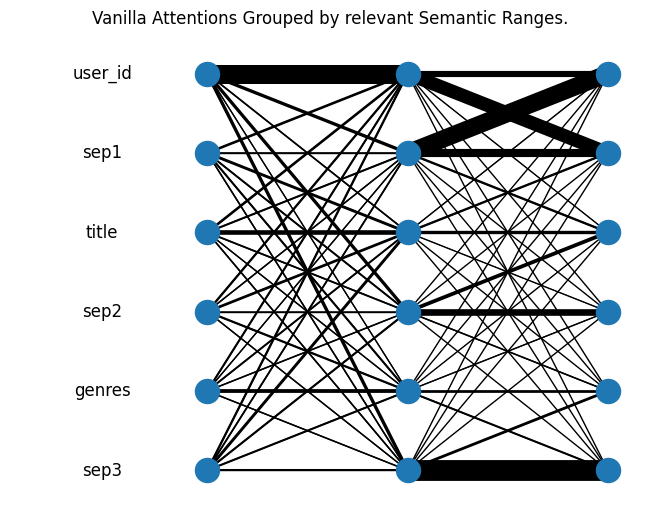

In [5]:
vanilla_bert_only_classifier.plot_attention_graph(vanilla_attentions, "Vanilla Attentions Grouped by relevant Semantic Ranges.")
#prompt_bert_only_classifier.plot_attention_graph(prompt_attentions, "Prompt Attentions Grouped by relevant Semantic Ranges.")
#adding_embedding_bert_only_classifier.plot_attention_graph(adding_embedding_attentions, "Embedding Attentions Grouped by relevant Semantic Ranges.")